In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


# Initial Setup

In [57]:
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128
# how much a model's weights and biases are adjusted  – too high = training becomes unstable, too low = the network learns very slowly and might get stuck in a local minimum before finding a better solution.
model_args['lr'] = 1e-2
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) Maintains the "direction" of weight updates
#If youse adam optimalizator you do not have to tweak momentum parameter
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 50
# logging frequency how often we display training progress
model_args['log_interval'] = 100

In [58]:
# load the MINST dataset via torchvision
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])
#Using default values (like 0.5/0.5) might work "okay," but It doesn’t provide an optimal data distribution
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
#test data separately – these are 10000 images the model has never seen before.
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

In [59]:
# define dataloaders - objects responsible for loading data during model training.
loader_kwargs = {'batch_size': model_args['batch_size'],
                 'num_workers': 2,
                 'pin_memory': True,
                 'shuffle': True} #randomly shuffles the data in each epoch – this prevents the model from memorizing the order and improves generalization.
#We create 3 separate DataLoaders – one for each data subset:
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

50000
10000
10000
391
torch.Size([28, 28])


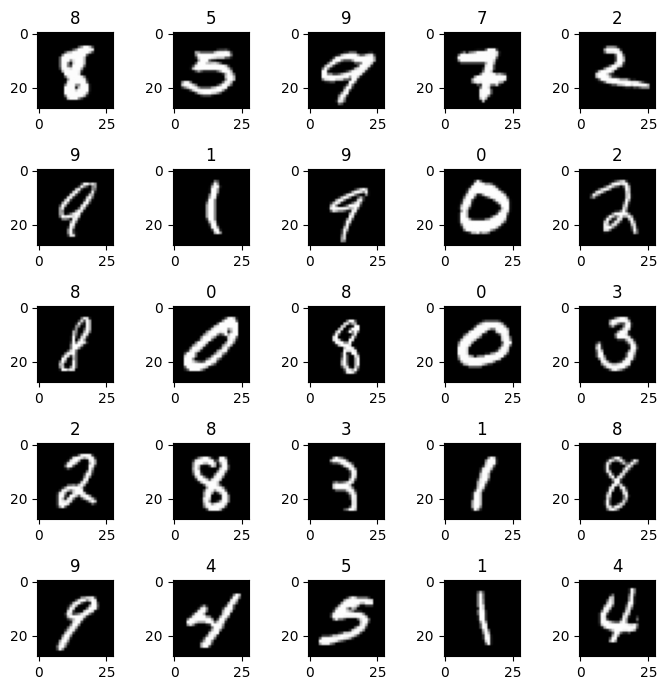

In [60]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) # we have data already divided into train & validation & test subsets
print(len(train_loader)) # no of train batches -391
example_number = 123
print(train_subset[example_number][0][0].shape) # single item shape

fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

# Code

In [61]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1      = nn.Conv2d(1,   8,  kernel_size=5)
        self.bn1        = nn.BatchNorm2d(8)
        self.conv2      = nn.Conv2d(8,  16, kernel_size=5)
        self.bn2        = nn.BatchNorm2d(16)
        self.conv2_drop = nn.Dropout2d()
        self.fc1        = nn.Linear(16*16, 64)
        self.bn_fc1     = nn.BatchNorm1d(64)
        self.fc2        = nn.Linear(64, 10)

    def forward(self, x):
        # 1st conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # 2nd conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # fully connected
        x = x.view(-1, 16*16)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [62]:
#And define training, testing, and plotting utils:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean')
            # get the index of class with the max log-probability
            prediction = output.argmax(dim=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu()

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()
#Analyzing of diagram
#If training loss decreases, but validation loss increases → overfitting.
#If both decrease → the model learns well.
#If both remain stationary → maybe the learning rate is too low or the model is too simple

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.426130
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.492560
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.370502
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.342319

Train set: Average loss: 0.4135
Val: Average loss: 0.0839, Accuracy: 9754/10000 (98%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.238084
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.198451
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.241035
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.170512

Train set: Average loss: 0.2153
Val: Average loss: 0.0620, Accuracy: 9804/10000 (98%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.244195
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.192886
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.223286
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.215022

Train set: Average loss: 0.1825
Val: Average loss: 0.0592, Accuracy: 9811/10000 (98%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.285069
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.128757
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.146550
Train 

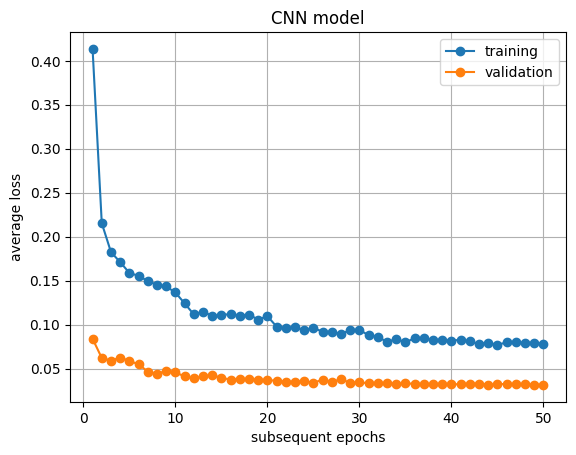

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []

model     = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=model_args['lr'], weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(1, model_args['epochs']+1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch))
    validation_loss.append(test(model, device, validation_loader, 'Val'))
    scheduler.step()

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

# Results

## Modification applied

1. Initial setup
```python
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # 2nd group
        x = self.conv2(x)
        # x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # fully connected layers
        x = x.view(-1, 64)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
```

2. Change to ADAM optimizer with scheduler
```python
optimizer = optim.Adam(model.parameters(), lr=model_args['lr'], weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
```

3. Add conv_2 droput layer
```python
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # 2nd group
        x = self.conv2(x)
        x = self.conv2_drop(x) # Change made here
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # fully connected layers
        x = x.view(-1, 64)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

4. Make bigger conv2d layers
```python
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1      = nn.Conv2d(1,   8,  kernel_size=5) # change here
        self.conv2      = nn.Conv2d(8,  16, kernel_size=5)  # change here
        self.conv2_drop = nn.Dropout2d()
        self.fc1        = nn.Linear(16*16, 64)  # change here
        self.fc2        = nn.Linear(64, 10)  # change here

    def forward(self, x):
        # 1st conv block
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # 2nd conv block
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # fully connected
        x = x.view(-1, 16*16)  # change here
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

5. Add batch normalization
```python
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1      = nn.Conv2d(1,   8,  kernel_size=5)
        self.bn1        = nn.BatchNorm2d(8)  # change here
        self.conv2      = nn.Conv2d(8,  16, kernel_size=5)
        self.bn2        = nn.BatchNorm2d(16)  # change here
        self.conv2_drop = nn.Dropout2d()
        self.fc1        = nn.Linear(16*16, 64)
        self.bn_fc1     = nn.BatchNorm1d(64)  # change here
        self.fc2        = nn.Linear(64, 10)

    def forward(self, x):
        # 1st conv block
        x = self.conv1(x)
        x = self.bn1(x)  # change here
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # 2nd conv block
        x = self.conv2(x)
        x = self.bn2(x)  # change here
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        # fully connected
        x = x.view(-1, 16*16)
        x = self.fc1(x)
        x = self.bn_fc1(x)  # change here
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

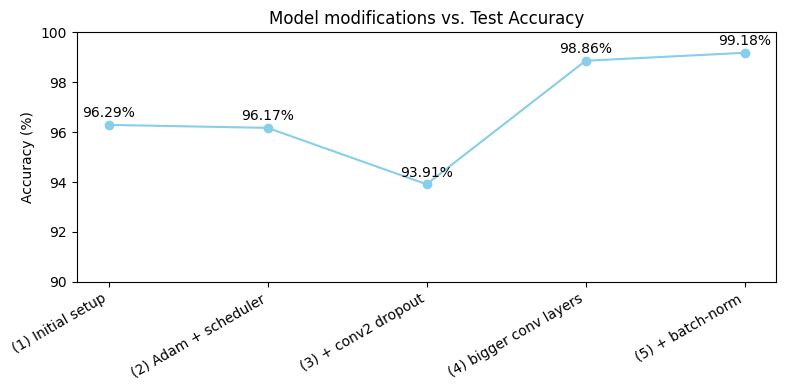

In [67]:
mods = [
    "(1) Initial setup",
    "(2) Adam + scheduler",
    "(3) + conv2 dropout",
    "(4) bigger conv layers",
    "(5) + batch-norm"
]
counts = [9629, 9617, 9391, 9886, 9918]
# compute percent
acc = [c/100 for c in counts]

plt.figure(figsize=(8,4))
plt.plot(mods, acc, '-o', color="skyblue")
plt.ylim(90, 100)
plt.ylabel("Accuracy (%)")
plt.title("Model modifications vs. Test Accuracy")
plt.xticks(rotation=30, ha="right")

# annotate points
for x, y in zip(mods, acc):
    plt.text(x, y + 0.3, f"{y:.2f}%", ha="center")

plt.tight_layout()
plt.show()

## Final Confiusion Matrix

c:\Users\Ignacy\Desktop\programowanie\Studia\sem6\AI_1\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


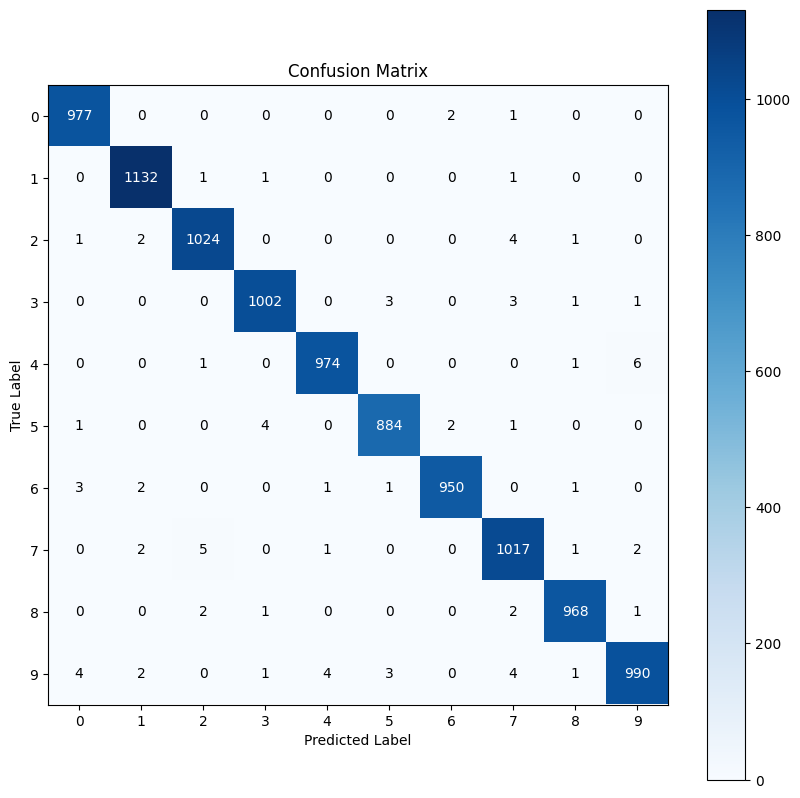

In [65]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))

for i in range(10):
    for j in range(10):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.colorbar()
plt.show()

## Why validation loss is smaller than train loss

The reason is that regularization techniques like dropout switches off some neurons during training, which can lead to a higher training loss compared to validation loss. During validation, all neurons are active, which can result in a lower validation loss.

## Why the model performs better

- **Richer feature extraction**: By increasing the number of convolutional filters (from 2→8 in conv1 and 4→16 in conv2), the network can capture more complex patterns and textures in the digit images.

- **Batch normalization**: Added after each convolutional and fully-connected layer, it stabilizes and accelerates training by reducing internal covariate shift.

- **Dropout regularization**: Applying `Dropout2d` in the second conv block and `dropout` in the FC layers prevents overfitting, which leads to better generalization on unseen data.

- **Adam optimizer with learning-rate scheduling**: Adam adapts individual learning rates for each parameter and the `StepLR` scheduler reduces the rate over time, helping the model converge more reliably and avoid poor local minima.

- **Increased capacity in FC layers**: Expanding the first fully-connected layer to 64 units provides greater capacity to learn non-linear combinations of features before final classification.

These combined enhancements reduce validation loss, improve convergence stability, and yield higher test accuracy compared to the initial simple CNN setup.